In [ ]:
!hostname

fedora


In [8]:
import torch, torchvision, torchaudio
print(f"Torch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}\nTorchaudio version: {torchaudio.__version__}")
print("CUDA available:", torch.cuda.is_available())

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
import mediapipe as mp
from PIL import Image

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
# Define transformations (resize, normalize, augment)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # These are standardization values that are commonly used
                         std=[0.229, 0.224, 0.225])
])

dataset_path = r"/home/rileyfrancis/Documents/Code/ASL-Letter-Classifier/dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)
targets = np.array([label for _, label in dataset.samples])


train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=123456
)

# --- Create subset datasets ---
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

# --- DataLoaders ---
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # Convolutional backbone
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)   # → 128x128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)   # → 64x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)   # → 32x32

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 32 * 32, 256)  # 131072 inputs
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNNClassifier(num_classes=len(train_data.dataset.classes))


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
def plot_confusion_matrix(model, data_loader, epoch, class_names):
    """Evaluate model and plot a log-scaled confusion matrix with annotations."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Avoid log(0) by adding +1 to empty cells
    cm_display = cm + 1

    fig, ax = plt.subplots(figsize=(10, 8))

    # Logarithmic color normalization
    sns.heatmap(
        cm_display,
        annot=True,           # print values in each square
        fmt=".0f",            # integer format
        cmap="Blues",         # color palette
        norm=LogNorm(),       # <-- logarithmic color scale
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Log-scaled frequency"}
    )

    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title(f"Confusion Matrix (Log Scale) — Epoch {epoch+1}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

Using device: cuda


Epoch 1/10 — avg loss: 1.0245


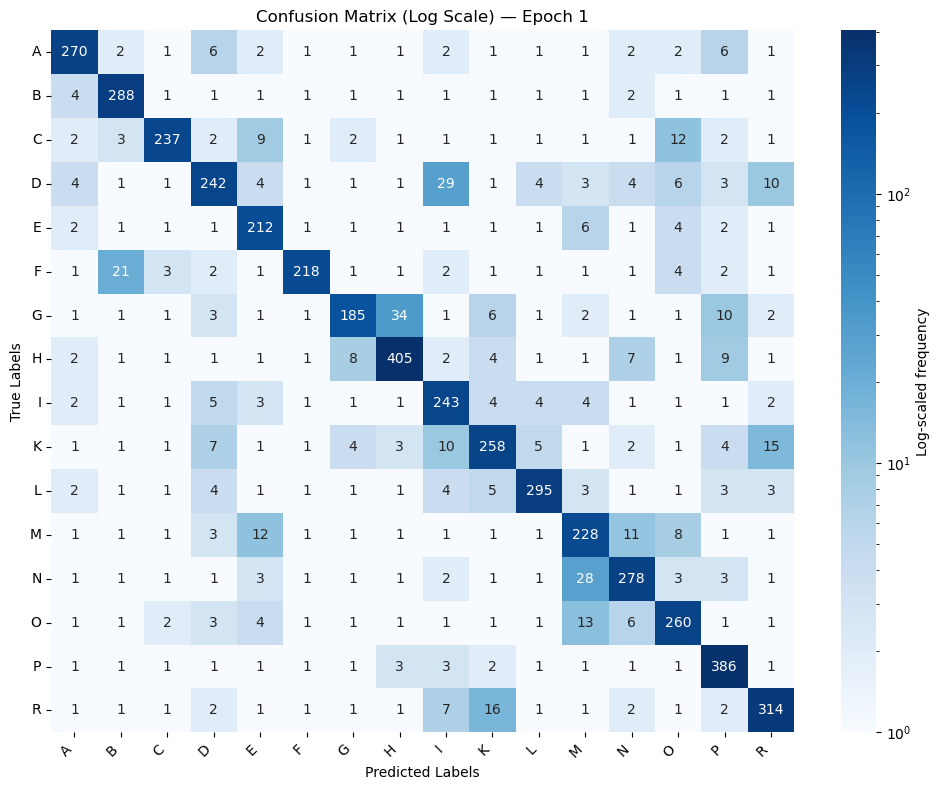

Epoch 2/10 — avg loss: 0.4011


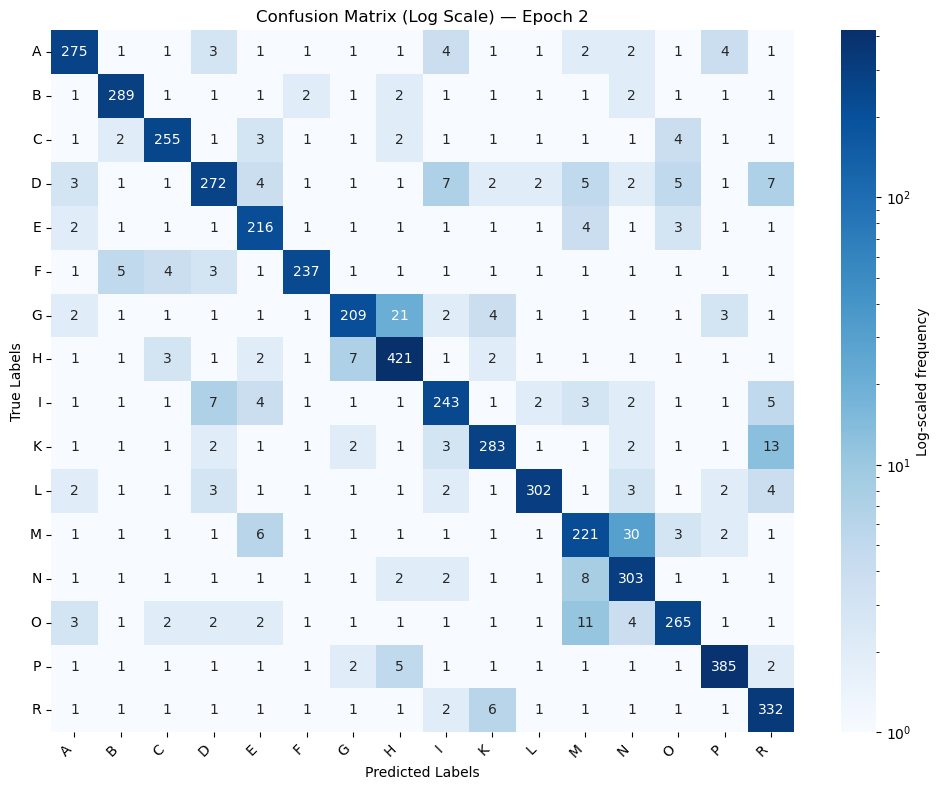

Epoch 3/10 — avg loss: 0.2712


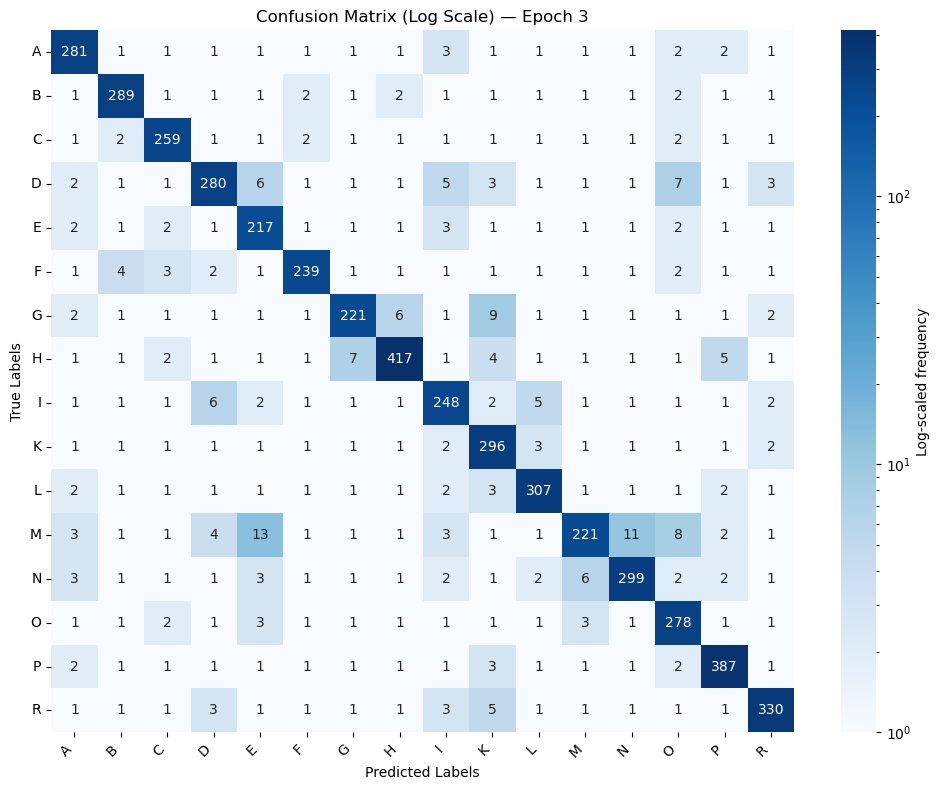

Epoch 4/10 — avg loss: 0.2157


Epoch 5/10 — avg loss: 0.1742


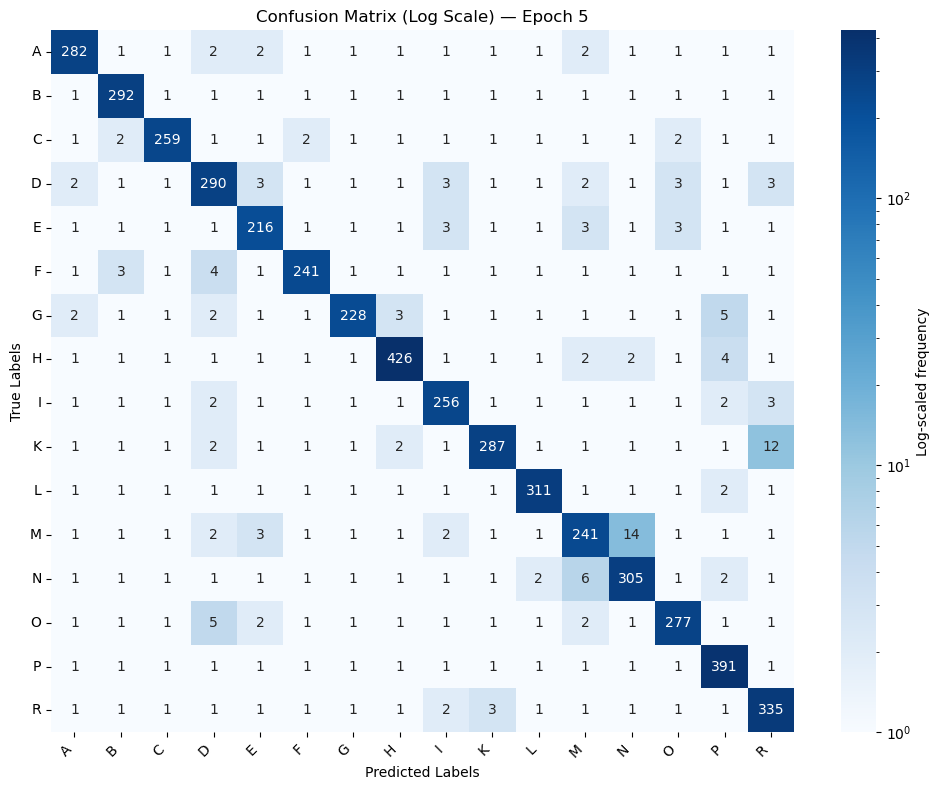

Epoch 6/10 — avg loss: 0.1516


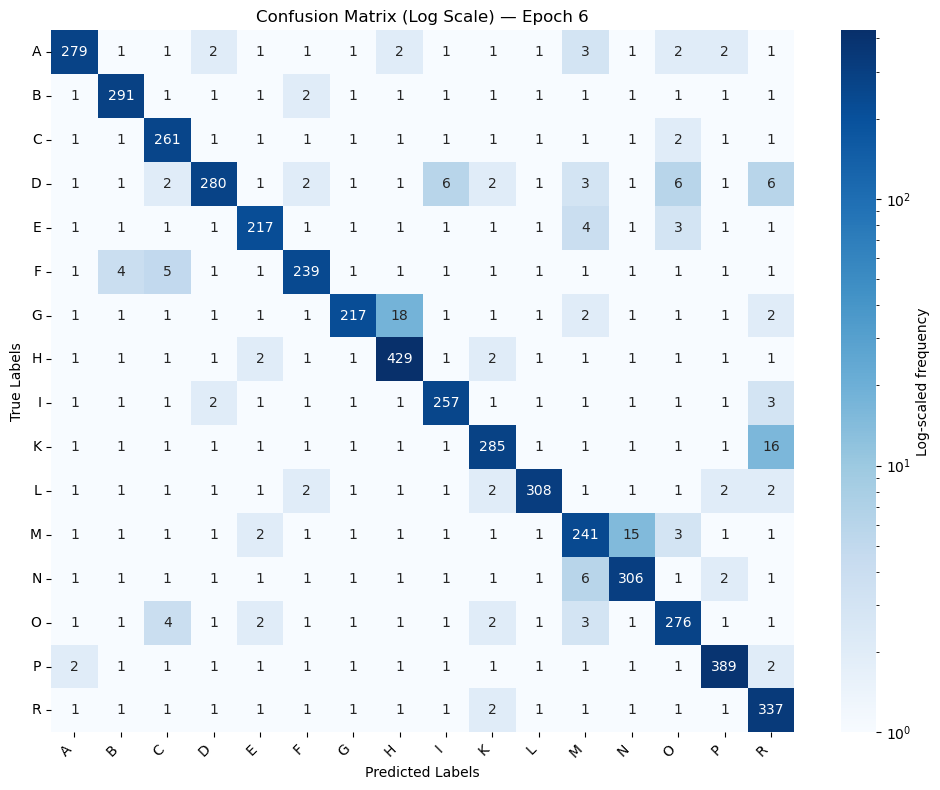

Epoch 7/10 — avg loss: 0.1315


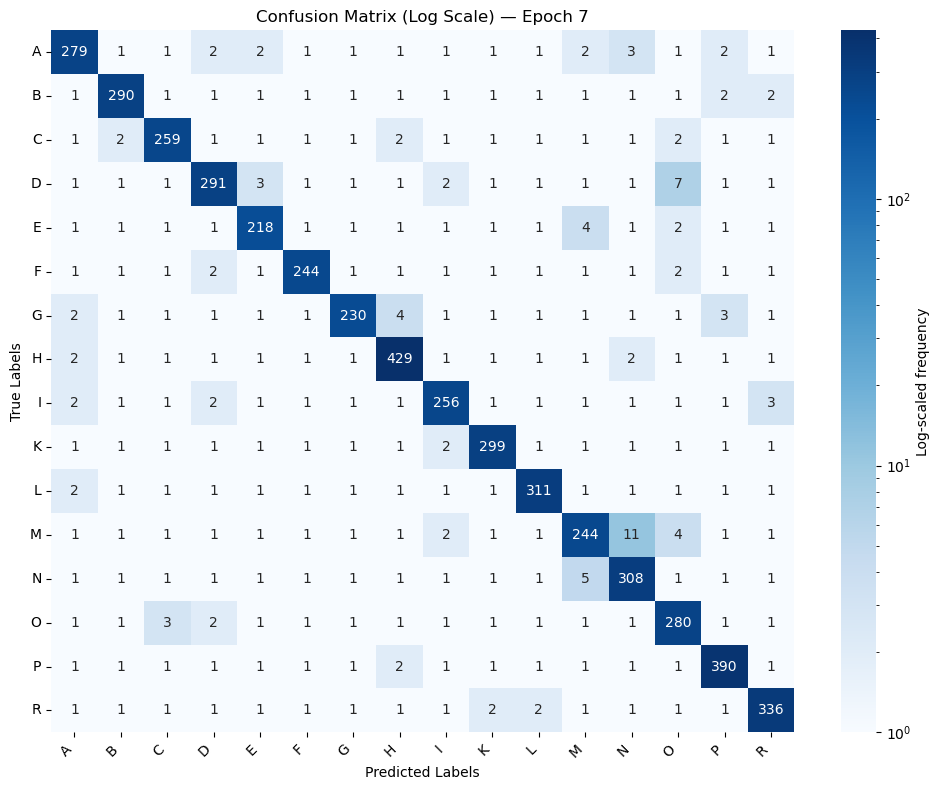

Epoch 8/10 — avg loss: 0.1154


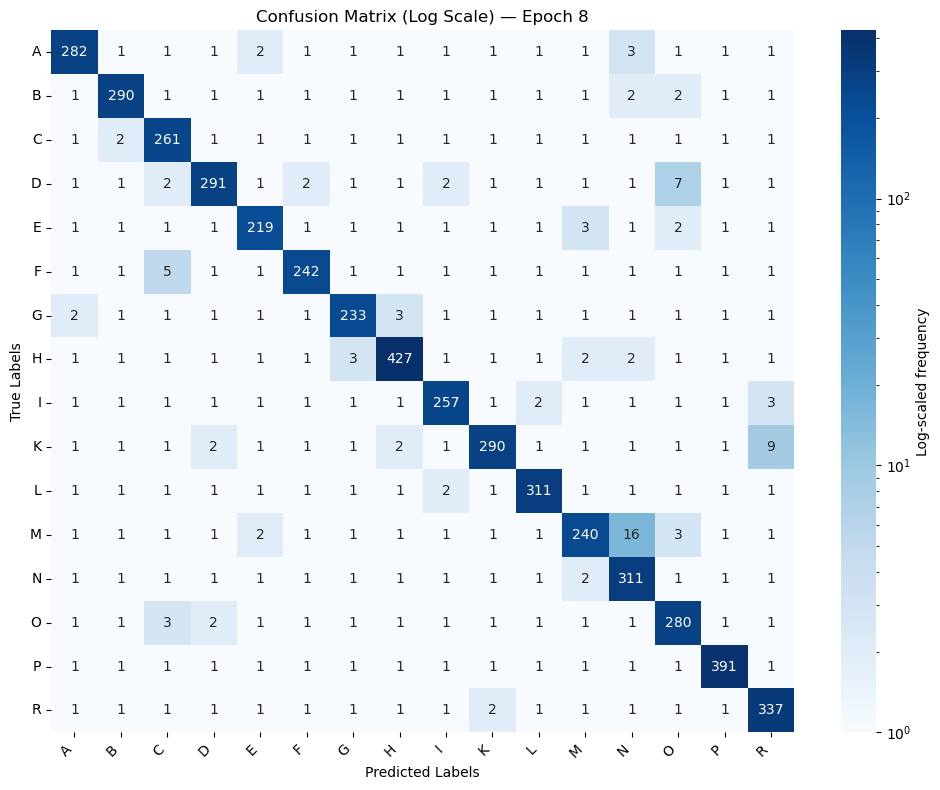

Epoch 9/10 — avg loss: 0.1110


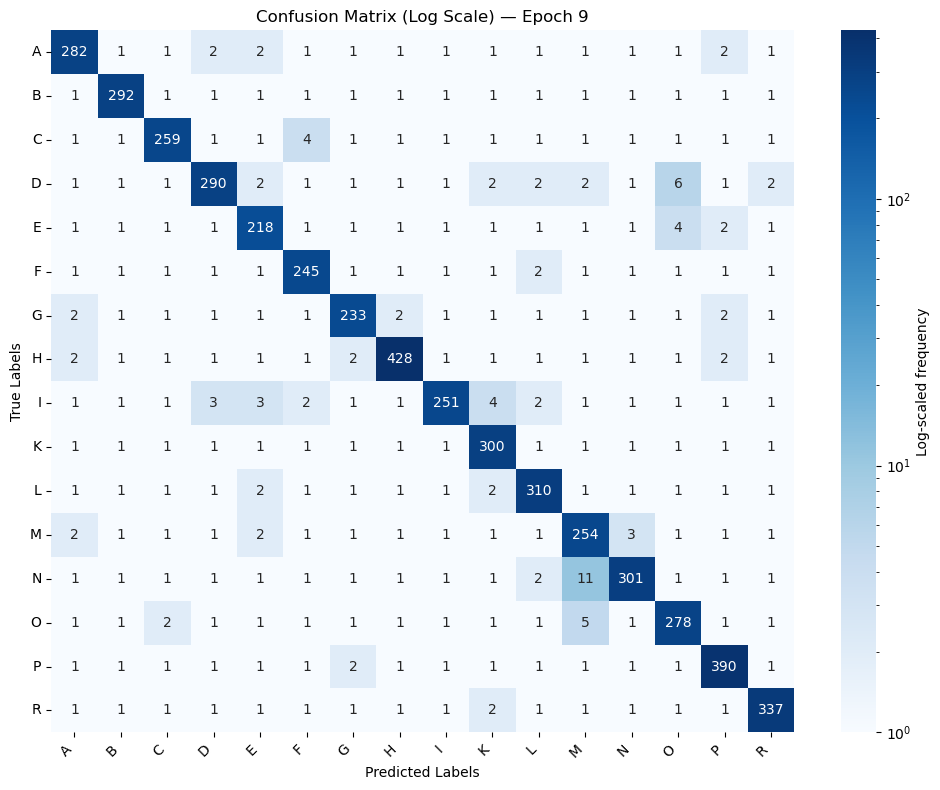

Epoch 10/10 — avg loss: 0.1029


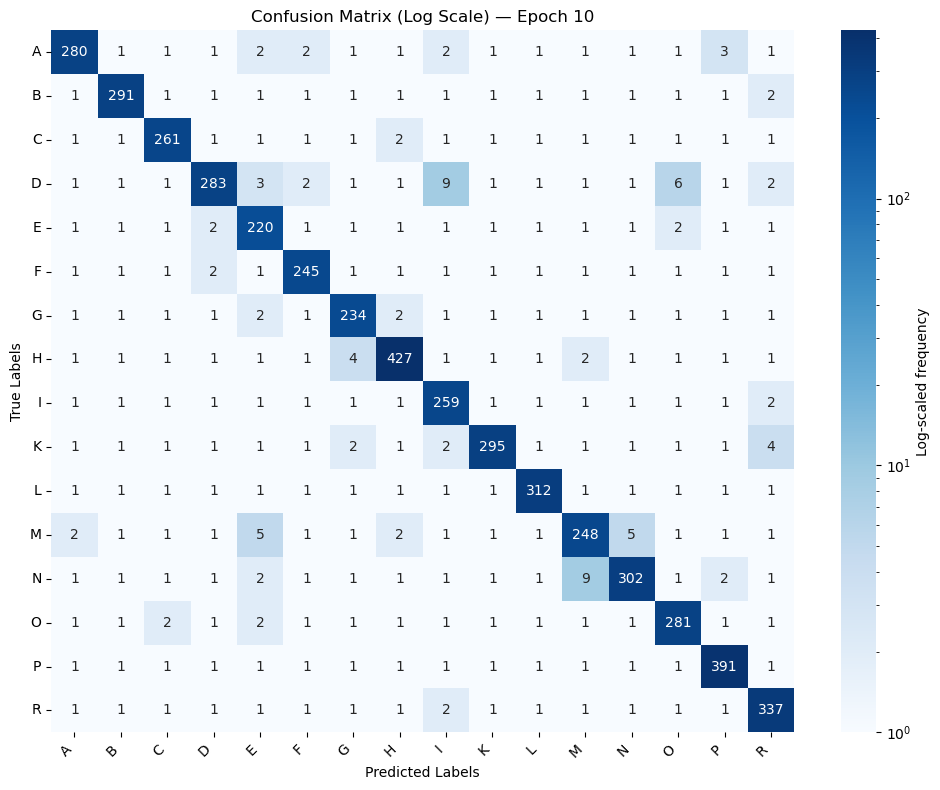

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 27 classes: A–Z + 'nothing'
classes = [chr(i) for i in range(65, 91)] + ['nothing']

# === Training Loop with tqdm ===
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Create tqdm progress bar for batches
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm postfix (optional — shows current loss)
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — avg loss: {avg_loss:.4f}")

    # 🧠 Plot confusion matrix after each epoch
    plot_confusion_matrix(model, val_loader, epoch, class_names=train_data.dataset.classes)

In [ ]:
torch.save(model, "asl_model.pth")

In [ ]:
from sklearn.metrics import classification_report
import torch

# Evaluate model on validation/test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Class names from your dataset
class_names = val_loader.dataset.dataset.classes  # since val_loader wraps a Subset

# Generate the report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3
)

print(report)

              precision    recall  f1-score   support

           A      0.996     0.989     0.993       284
           B      1.000     1.000     1.000       291
           C      0.996     0.977     0.986       261
           D      0.993     0.940     0.966       299
           E      0.961     0.995     0.978       221
           F      0.996     1.000     0.998       245
           G      0.975     0.983     0.979       235
           H      0.991     0.981     0.986       430
           I      0.952     0.996     0.974       259
           K      0.997     0.977     0.986       299
           L      0.997     0.997     0.997       311
           M      0.980     0.953     0.966       257
           N      0.977     0.971     0.974       311
           O      0.962     0.993     0.977       282
           P      0.987     0.997     0.992       390
           R      0.980     0.997     0.988       337

    accuracy                          0.984      4712
   macro avg      0.984   

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Path to your test image
image_path = r"/home/rif17002/Project/dataset/D/1762654609922.jpg"

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load and preprocess image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # shape: [1, 3, 256, 256]

model.to(device)
model.eval()

# Run inference
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)[0]  # shape: [27]
    predicted_idx = torch.argmax(probs).item()

# Class labels
class_names = train_data.dataset.classes

# Print probabilities for all classes
print("Class probabilities:")
for i, p in enumerate(probs.cpu().numpy()):
    print(f"{class_names[i]:<10}: {p*100:.2f}%")

# Print final prediction
predicted_label = class_names[predicted_idx]
print("\nPredicted class:", predicted_label)


Class probabilities:
A         : 0.00%
B         : 0.00%
C         : 10.58%
D         : 15.08%
E         : 0.24%
F         : 0.01%
G         : 0.00%
H         : 0.00%
I         : 0.00%
K         : 0.00%
L         : 0.00%
M         : 0.07%
N         : 0.00%
O         : 74.02%
P         : 0.00%
R         : 0.00%

Predicted class: O
